In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from IPython.display import Audio, display

import torch
import torch.nn as nn
from torch.nn import init
import torchaudio
import math, random
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from torchsummary import summary
from matplotlib import cm
import matplotlib as mpl

from sklearn.metrics import accuracy_score


ModuleNotFoundError: No module named 'pandas'

In [ ]:
dataset='C:/Users/Engem/Downloads/data/GroundType/'

ID=[]
label=[]
ClassID=[]
 
# iterate over files in that directory

for folder in os.listdir(dataset):                               #go into the directory
    for filename in os.listdir(dataset+ str(folder)):          #go in every class 
        f = os.path.join(dataset+ str(folder), filename) #scan through every file in that class
        if os.path.isfile(f):
            ID.append(f.split('\\')[-1])
            label.append(str(folder))
            
for i in range(len(label)):
    if(label[i]=='Concrete'):
        ClassID.append(0)      
    else:
        ClassID.append(1)


In [ ]:
dset=pd.DataFrame()
dset['ID']=ID
dset['label']=label
dset['ClassID']=ClassID


In [ ]:
dset.head(150)

,ID,label,ClassID
0,Concrete-01.wav,Concrete,0
1,Concrete-02.wav,Concrete,0
2,Concrete-03.wav,Concrete,0
3,Concrete-04.wav,Concrete,0
4,Concrete-05.wav,Concrete,0
...,...,...,...
145,Grass-66.wav,Grass,1
146,Grass-67.wav,Grass,1
147,Grass-68.wav,Grass,1
148,Grass-69.wav,Grass,1


In [ ]:
dset.to_csv('C:/Users/Eman Badr/Downloads/data/data_binary.csv')

In [ ]:
df = pd.read_csv('C:/Users/Eman Badr/Downloads/data/data_binary.csv')

In [ ]:
df['ID'].loc[150]

'Grass-71.wav'

In [ ]:
Grass = 'C:/Users/Eman Badr/Downloads/data/GroundType/Grass/'
path=os.path.join(Grass, df['ID'].loc[95])
print(path)

C:/Users/Eman Badr/Downloads/data/GroundType/Grass/Grass-16.wav


Shape of waveform: torch.Size([1, 124800])
Sample rate of waveform: 48000
(tensor([[-0.0592, -0.0435, -0.0316,  ...,  0.0034,  0.0022,  0.0040]]), 48000)


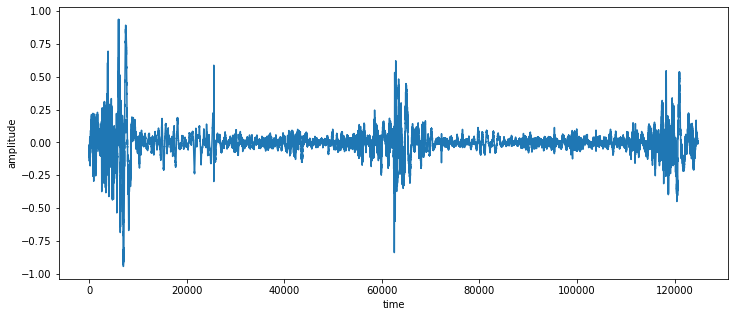

In [ ]:
def plot_audio(filename):
    waveform, sample_rate = torchaudio.load(filename)

    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))

    fig1, ax1 = plt.subplots(figsize=(12, 5))    
  
    ax1.plot(waveform[0,:].numpy())

    ax1.set_xlabel('time') 
    ax1.set_ylabel("amplitude")

    return waveform, sample_rate


aud= plot_audio(path)
print(aud)

Shape of spec: torch.Size([1, 64, 244])
Shape of spec: torch.Size([1, 64, 244])


tensor([[[ 25.6515,  28.2962,   4.8965,  ...,  18.2590,  29.0096,  25.8288],
         [ 21.6490,  25.8476,  25.9321,  ...,  23.0932,  26.6949,  23.3411],
         [ 14.4054,  20.4386,  27.3097,  ...,  19.8471,  22.0939,  18.7014],
         ...,
         [-25.9459, -33.8293, -33.8293,  ..., -33.8293, -33.8293, -33.8293],
         [-25.3798, -33.8293, -33.8293,  ..., -33.8293, -33.8293, -33.8293],
         [-27.3806, -33.8293, -33.8293,  ..., -33.3263, -33.8293, -33.8293]]])

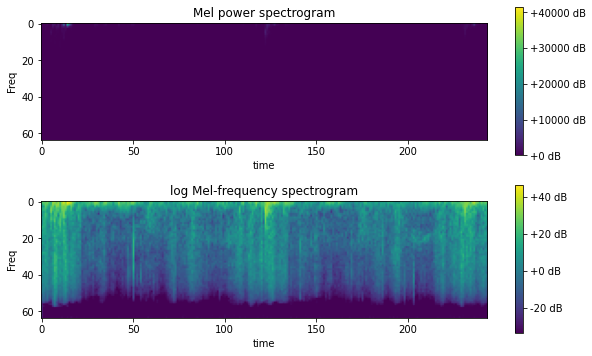

In [ ]:
def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig, sr = aud
    top_db = 80
    
    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec1 = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec1)
    
    
    print("Shape of spec: {}".format(spec1.size()))
    print("Shape of spec: {}".format(spec.size()))
     
    fig, ax = plt.subplots(nrows=2, ncols=1, sharey=True,  figsize=(10, 6))
   
    
    s= ax[0].imshow(spec1[0,:,:].numpy())
    s1= ax[1].imshow(spec[0,:,:].numpy())
    ax[0].grid(False)
    ax[1].grid(False)
    fig.colorbar(s, ax=ax[0], format='%+2.0f dB') 
    fig.colorbar(s1, ax=ax[1], format='%+2.0f dB')    
    ax[0].set_title('Mel power spectrogram') 
    ax[0].set_xlabel('time') 
    ax[0].set_ylabel("Freq")
    
    ax[1].set_title('log Mel-frequency spectrogram')
    ax[1].set_xlabel('time') 
    ax[1].set_ylabel("Freq")


    return (spec)


spectro_gram(aud)

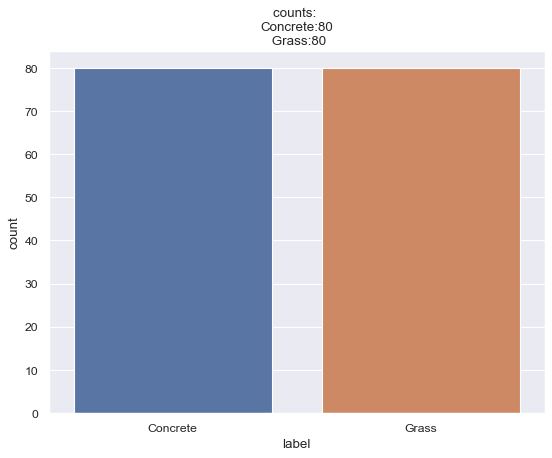

In [ ]:
plt.figure(figsize=(8,6),dpi=80)
sn.set_theme(style="darkgrid")
sn.countplot(x ='label',data=dset)
plt.title('counts: \n' +'Concrete:'+str(dset.label.value_counts()[0])+'\n Grass:'+str(dset.label.value_counts()[1]))
plt.show()

In [ ]:
print(dset.label.unique())

['Concrete' 'Grass']


In [ ]:
print("Number of training examples=", dset.shape[0], "  Number of classes=", len(dset.label.unique()))

Number of training examples= 160   Number of classes= 2


In [ ]:
# Read file

df['ID'] = df['label'].astype(str) + '/' + df['ID'].astype(str)
# Take relevant columns
df = df[['ID', 'ClassID']]
df.head(150)

,ID,ClassID
0,Concrete/Concrete-01.wav,0
1,Concrete/Concrete-02.wav,0
2,Concrete/Concrete-03.wav,0
3,Concrete/Concrete-04.wav,0
4,Concrete/Concrete-05.wav,0
...,...,...
145,Grass/Grass-66.wav,1
146,Grass/Grass-67.wav,1
147,Grass/Grass-68.wav,1
148,Grass/Grass-69.wav,1


In [ ]:
class AudioUtil():
    def open(audio_file): # Load an audio file. Return the signal as a tensor and the sample rate
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    
    
    def resample(aud, newsr):
        sig, sr = aud
  
        if (sr == newsr):# Nothing to do
            #print('newsr',newsr)
            return aud

        num_channels = sig.shape[0]# Resample first channel
        #print('num_channels',num_channels)
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        #print("Shape of transformed waveform: {}".format(resig.size()))

        #plt.figure()
        #plt.plot(resig[0,:].numpy())
        #print('resig',resig)
        #print('resig',resig.shape)

        return (resig, newsr)
    
    

    def pad_trunc(aud, max_ms):
        sig, sr = aud
        #print('sig',sig)
        #print('sr',sr)
        #print(sig.shape)
        num_rows, sig_len = sig.shape
        #print('num_rows',num_rows)
        #print('sig_len',sig_len)
        max_len = sr//1000 * max_ms
        #print('max_len',max_len)

        if (sig_len > max_len): # Truncate the signal to the given length
           sig = sig[:,:max_len]
           #print('sig_pad_trunc',sig.shape)
           #plt.figure()
           #plt.plot(sig[0,:].numpy())
         

        elif (sig_len < max_len): # Length of padding to add at the beginning and end of the signal
              pad_begin_len = random.randint(0, max_len - sig_len)
              #print('pad_begin_len',pad_begin_len)
              pad_end_len = max_len - sig_len - pad_begin_len
              #print('pad_end_len',pad_end_len)
              # Pad with 0s
              pad_begin = torch.zeros((num_rows, pad_begin_len))
              #print('pad_begin',pad_begin)
              pad_end = torch.zeros((num_rows, pad_end_len))
              sig = torch.cat((pad_begin, sig, pad_end),1) 
              #print('sig_pad_trunc', sig.shape)
              #plt.figure()
              #sig1=sig[0,:].numpy()
              #plt.plot(sig1)      
                                     
        return (sig, sr)          
                                      

    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig, sr = aud
        top_db = 80
    
        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        
        #print("Shape of spec: {}".format(spec.size()))
        return (spec)
    
    #def play_audio(waveform, sample_rate):
        #display(Audio(waveform[0], rate=sample_rate))
        
        

In [ ]:
 #dataset=[]
# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
    def __init__(self, df, data_path):
        self.df = df
        self.data_path = str(data_path)
        self.duration = 4000
        self.sr = 48000
        dataset=[]  
        # ----------------------------
        # Number of items in dataset
        # ----------------------------
    def __len__(self):
        return len(self.df)    
    
       # ----------------------------
       # Get i'th item in dataset
       # ----------------------------
    def __getitem__(self, idx):
       # Absolute file path of the audio file - concatenate the audio directory withnthe relative path
       audio_file = self.data_path + self.df.loc[idx, 'ID']
       #print(audio_file)
    
       class_id = self.df.loc[idx, 'ClassID']
        
       ID = self.df.loc[idx, 'ID']

       aud = AudioUtil.open(audio_file)

       reaud = AudioUtil.resample(aud, self.sr)

       dur_aud= AudioUtil.pad_trunc(reaud, self.duration)
       #print(dur_aud)
       sgram_features = AudioUtil.spectro_gram(dur_aud)
    
       #listen = AudioUtil.play_audio(dur_aud,self.sr)
       
       return  sgram_features, class_id

In [ ]:
myds = SoundDS(df, dataset)
print(myds[20])


(tensor([[[-36.6191, -36.6191, -36.6191,  ..., -36.6191, -36.6191, -36.6191],
         [-36.6191, -36.6191, -36.6191,  ..., -36.6191, -36.6191, -36.6191],
         [-36.6191, -36.6191, -36.6191,  ..., -36.6191, -36.6191, -36.6191],
         ...,
         [-36.6191, -36.6191, -36.6191,  ..., -36.6191, -36.6191, -36.6191],
         [-36.6191, -36.6191, -36.6191,  ..., -36.6191, -36.6191, -36.6191],
         [-36.6191, -36.6191, -36.6191,  ..., -36.6191, -36.6191, -36.6191]]]), 0)


In [ ]:
# data loader

random_seed = 64
torch.manual_seed(random_seed)
batch_size = 16

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])
len(train_ds), len(val_ds)

# Create training and validation data loaders
train_loader = torch.utils.data.DataLoader(train_ds, batch_size= batch_size, shuffle=True)
print(len(train_loader))
test_loader = torch.utils.data.DataLoader(val_ds, batch_size= batch_size, shuffle=False)
print(len(test_loader))
#for i, batch in enumerate(train_loader):
   #print(i, batch)

8
2


In [ ]:
examples = iter(train_loader)
data, targets= examples.next()
print(data.shape, targets.shape)
#print(' '.join(f'{classes[targets[j]]:5s}' for j in range(batch_size)))



#examples = iter(test_loader)
#example_data,example_targets= examples.next()
#print(example_data.shape, example_targets.shape)
#print(' '.join(f'{classes[example_targets[j]]:5s}' for j in range(batch_size)))

torch.Size([16, 1, 64, 376]) torch.Size([16])


In [ ]:
class AudioClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        # first Convolution Block
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
        self.bn1 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')
        self.conv1.bias.data.zero_()

        # Second Convolution Block
        self.conv2 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv2.weight, mode='fan_out', nonlinearity='relu')
        self.conv2.bias.data.zero_()
        
        #linear ouput
        self.ap = nn.AdaptiveMaxPool2d(output_size=1)# Input: (N, C, Hin, Win).Output: (N, C, S0, S1), where S=output_size.
        self.fc1 = nn.Linear(in_features=64, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=1)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))# Run the convolutional blocks
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.ap(x)# Adaptive pool
        x = torch.flatten(x, 1) # flatten for input to linear layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x= torch.sigmoid(x)
        return x            # Final output



In [ ]:
#TRAINING THE NETWORK

num_epochs= 50


def train(model, train_loader, optimizer,scheduler):
        model.train()
        loss_total = 0
        y_true = []
        y_pred = []
        for i, data in enumerate(train_loader):
            #LOADING THE DATA IN A BATCH
            data, target = data[0], data[1]
            target= target.float()
            
            # clear the gradients
            optimizer.zero_grad()
                        
            # Normalize the inputs
            inputs_m, inputs_s = data.mean(), data.std()
            data = (data - inputs_m) / inputs_s
        
            #FORWARD PASS
            output = model(data)
            loss = criterion(output, target.unsqueeze(1)) 
        
            #BACKWARD AND OPTIMIZE
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # calculating the total_loss for checking
            loss_total += loss.item()
        
            # PREDICTIONS 
            pred = np.round(output.detach().numpy())
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.tolist())
        
        # Print stats at the end of the epoch
        train_loss = loss_total /len(train_loader)
        acc= 100* accuracy_score(y_true,y_pred)
        print(f'Epoch: {epoch}, Loss: {train_loss:.2f}, Accuracy on training set is: {acc:.2f}')
        train_accu.append(acc)
        train_losses.append(train_loss)


In [ ]:
#TESTING THE MODE

def test(model, test_loader):
        model.eval()
        loss_total = 0
        y_true = []
        y_pred = []
    
        with torch.no_grad():
             for i, data in enumerate(test_loader):
            
                #LOADING THE DATA IN A BATCH
                data, target = data[0], data[1]
                target= target.float()
            
                # Normalize the inputs
                inputs_m, inputs_s = data.mean(), data.std()
                data = (data - inputs_m) / inputs_s
            
                #FORWARD PASS
                output = model(data)
                loss = criterion(output, target.unsqueeze(1)) 
            
                # calculating the total_loss for checking
                loss_total += loss.item()
                       
                #PREDICTIONS
                pred = np.round(output)
                y_true.extend(target.tolist()) 
                y_pred.extend(pred.tolist())
                conf_matrix= confusion_matrix(y_true, y_pred)
                conf_matrix_df = pd.DataFrame(conf_matrix , index = ['Concrete','Grass'], columns = ['Concrete','Grass'])
    
        # Print stats at the end of the epoch
        test_loss = loss_total /len(test_loader)
        acc= 100* accuracy_score(y_true,y_pred)
        print(f'Epoch: {epoch}, Loss: {test_loss:.2f}, Accuracy on testing set is: {acc:.2f}')
        print(conf_matrix)
        test_accu.append(acc)
        test_losses.append(test_loss) 
        
        
        plt.figure(figsize=(5,4))
        sn.heatmap(conf_matrix_df, annot=True , cmap="YlGnBu")
        plt.title('Confusion Matrix')
        plt.ylabel('Actal Values')
        plt.xlabel('Predicted Values')
        plt.show()


In [ ]:
model = AudioClassifier()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_loader)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

In [ ]:
summary(model, (1, 64, 376))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 33, 189]             160
       BatchNorm2d-2          [-1, 16, 33, 189]              32
            Conv2d-3           [-1, 64, 17, 95]           9,280
       BatchNorm2d-4           [-1, 64, 17, 95]             128
 AdaptiveMaxPool2d-5             [-1, 64, 1, 1]               0
            Linear-6                   [-1, 32]           2,080
            Linear-7                    [-1, 1]              33
Total params: 11,713
Trainable params: 11,713
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 3.10
Params size (MB): 0.04
Estimated Total Size (MB): 3.24
----------------------------------------------------------------


Epoch: 0, Loss: 0.85, Accuracy on training set is: 48.44
Epoch: 0, Loss: 0.69, Accuracy on testing set is: 59.38
[[ 1 13]
 [ 0 18]]


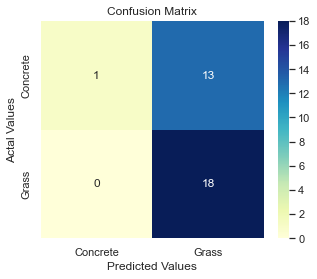

Epoch: 1, Loss: 0.71, Accuracy on training set is: 53.91
Epoch: 1, Loss: 0.70, Accuracy on testing set is: 34.38
[[ 0 14]
 [ 7 11]]


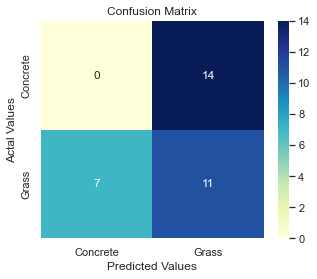

Epoch: 2, Loss: 0.67, Accuracy on training set is: 59.38
Epoch: 2, Loss: 0.69, Accuracy on testing set is: 53.12
[[ 4 10]
 [ 5 13]]


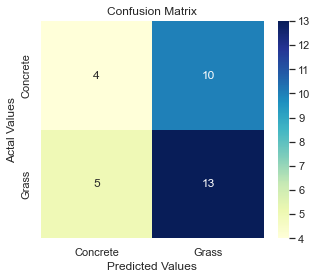

Epoch: 3, Loss: 0.70, Accuracy on training set is: 51.56
Epoch: 3, Loss: 0.70, Accuracy on testing set is: 50.00
[[ 9  5]
 [11  7]]


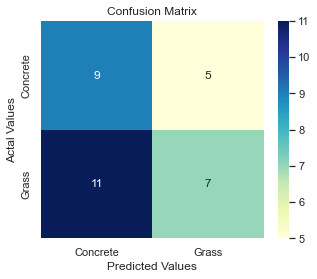

Epoch: 4, Loss: 0.65, Accuracy on training set is: 60.94
Epoch: 4, Loss: 0.70, Accuracy on testing set is: 50.00
[[ 9  5]
 [11  7]]


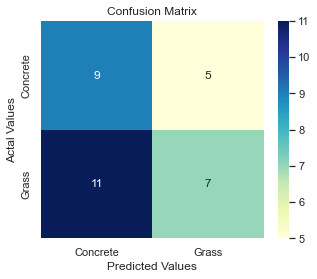

Epoch: 5, Loss: 0.65, Accuracy on training set is: 65.62
Epoch: 5, Loss: 0.67, Accuracy on testing set is: 75.00
[[ 9  5]
 [ 3 15]]


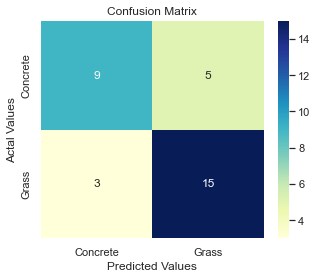

Epoch: 6, Loss: 0.62, Accuracy on training set is: 76.56
Epoch: 6, Loss: 0.66, Accuracy on testing set is: 62.50
[[10  4]
 [ 8 10]]


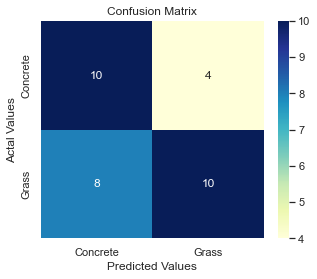

Epoch: 7, Loss: 0.58, Accuracy on training set is: 82.03
Epoch: 7, Loss: 0.62, Accuracy on testing set is: 68.75
[[ 9  5]
 [ 5 13]]


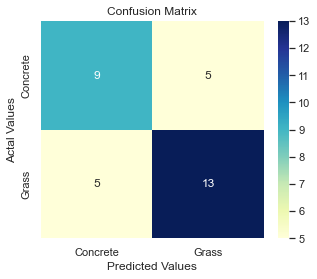

Epoch: 8, Loss: 0.57, Accuracy on training set is: 78.91
Epoch: 8, Loss: 0.63, Accuracy on testing set is: 78.12
[[14  0]
 [ 7 11]]


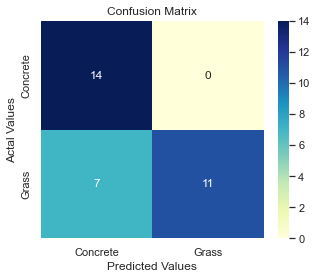

Epoch: 9, Loss: 0.54, Accuracy on training set is: 77.34
Epoch: 9, Loss: 0.50, Accuracy on testing set is: 84.38
[[14  0]
 [ 5 13]]


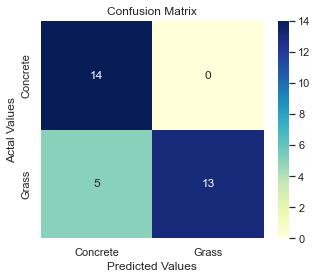

Epoch: 10, Loss: 0.53, Accuracy on training set is: 79.69
Epoch: 10, Loss: 0.61, Accuracy on testing set is: 56.25
[[13  1]
 [13  5]]


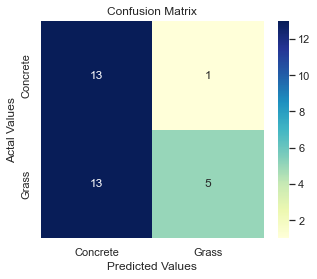

Epoch: 11, Loss: 0.47, Accuracy on training set is: 89.06
Epoch: 11, Loss: 0.53, Accuracy on testing set is: 81.25
[[12  2]
 [ 4 14]]


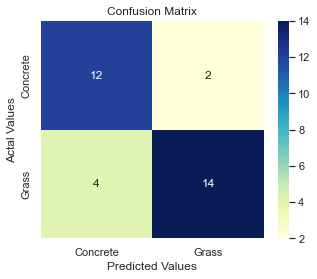

Epoch: 12, Loss: 0.46, Accuracy on training set is: 84.38
Epoch: 12, Loss: 0.51, Accuracy on testing set is: 75.00
[[10  4]
 [ 4 14]]


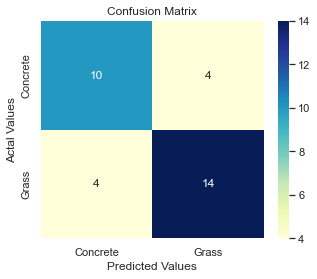

Epoch: 13, Loss: 0.44, Accuracy on training set is: 86.72
Epoch: 13, Loss: 0.56, Accuracy on testing set is: 68.75
[[14  0]
 [10  8]]


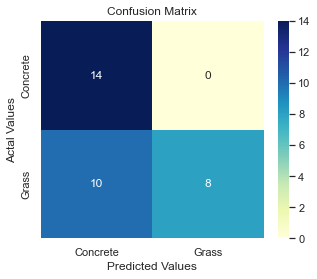

Epoch: 14, Loss: 0.39, Accuracy on training set is: 85.94
Epoch: 14, Loss: 0.40, Accuracy on testing set is: 87.50
[[12  2]
 [ 2 16]]


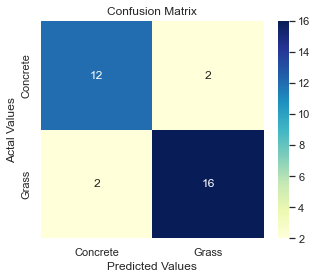

Epoch: 15, Loss: 0.37, Accuracy on training set is: 88.28
Epoch: 15, Loss: 0.40, Accuracy on testing set is: 90.62
[[12  2]
 [ 1 17]]


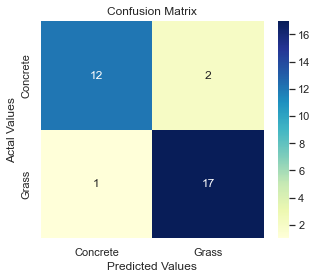

Epoch: 16, Loss: 0.33, Accuracy on training set is: 87.50
Epoch: 16, Loss: 0.32, Accuracy on testing set is: 90.62
[[13  1]
 [ 2 16]]


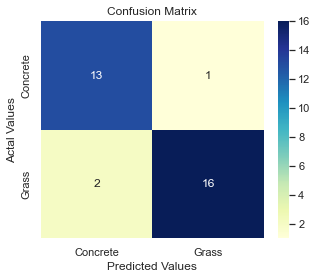

Epoch: 17, Loss: 0.27, Accuracy on training set is: 94.53
Epoch: 17, Loss: 0.33, Accuracy on testing set is: 90.62
[[11  3]
 [ 0 18]]


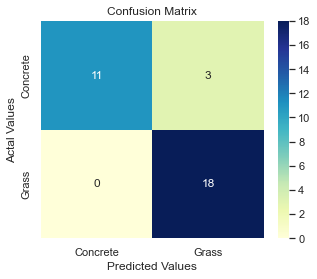

Epoch: 18, Loss: 0.26, Accuracy on training set is: 90.62
Epoch: 18, Loss: 0.30, Accuracy on testing set is: 90.62
[[12  2]
 [ 1 17]]


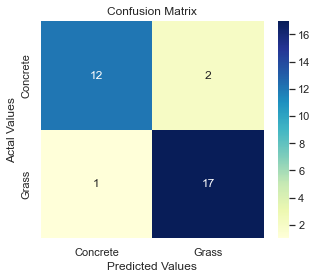

Epoch: 19, Loss: 0.22, Accuracy on training set is: 93.75
Epoch: 19, Loss: 0.29, Accuracy on testing set is: 87.50
[[13  1]
 [ 3 15]]


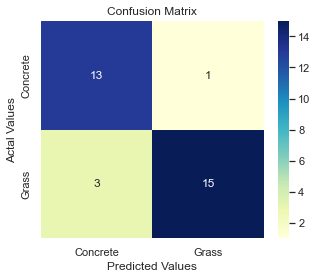

Epoch: 20, Loss: 0.29, Accuracy on training set is: 87.50
Epoch: 20, Loss: 0.28, Accuracy on testing set is: 93.75
[[14  0]
 [ 2 16]]


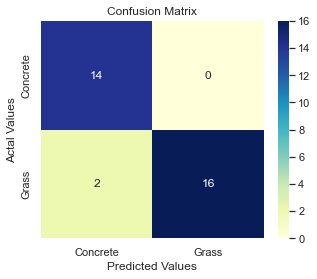

Epoch: 21, Loss: 0.21, Accuracy on training set is: 93.75
Epoch: 21, Loss: 0.26, Accuracy on testing set is: 90.62
[[12  2]
 [ 1 17]]


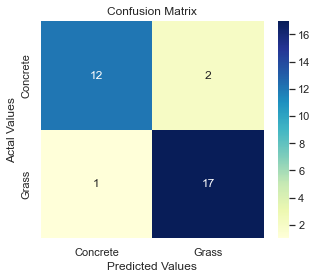

Epoch: 22, Loss: 0.17, Accuracy on training set is: 97.66
Epoch: 22, Loss: 0.26, Accuracy on testing set is: 90.62
[[12  2]
 [ 1 17]]


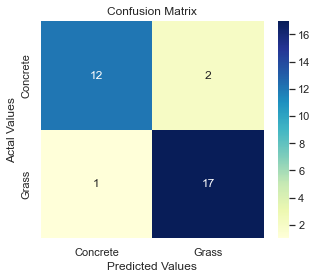

Epoch: 23, Loss: 0.16, Accuracy on training set is: 96.88
Epoch: 23, Loss: 0.26, Accuracy on testing set is: 90.62
[[13  1]
 [ 2 16]]


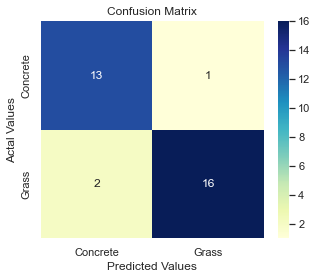

Epoch: 24, Loss: 0.14, Accuracy on training set is: 98.44
Epoch: 24, Loss: 0.18, Accuracy on testing set is: 100.00
[[14  0]
 [ 0 18]]


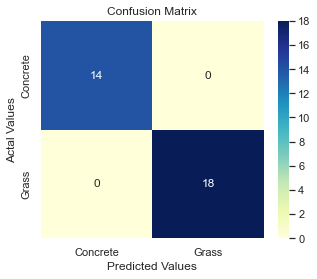

Epoch: 25, Loss: 0.15, Accuracy on training set is: 96.88
Epoch: 25, Loss: 0.15, Accuracy on testing set is: 96.88
[[14  0]
 [ 1 17]]


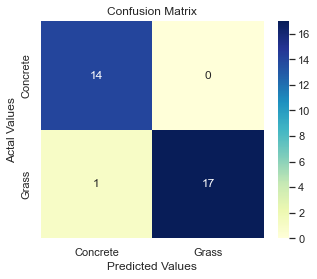

Epoch: 26, Loss: 0.14, Accuracy on training set is: 98.44
Epoch: 26, Loss: 0.17, Accuracy on testing set is: 96.88
[[14  0]
 [ 1 17]]


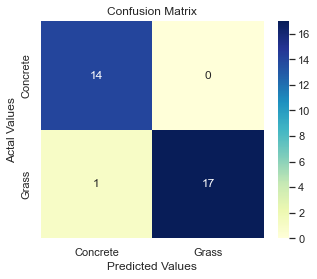

Epoch: 27, Loss: 0.12, Accuracy on training set is: 98.44
Epoch: 27, Loss: 0.35, Accuracy on testing set is: 87.50
[[14  0]
 [ 4 14]]


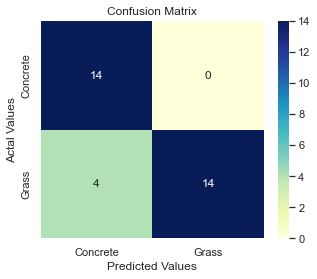

Epoch: 28, Loss: 0.14, Accuracy on training set is: 94.53
Epoch: 28, Loss: 0.16, Accuracy on testing set is: 90.62
[[13  1]
 [ 2 16]]


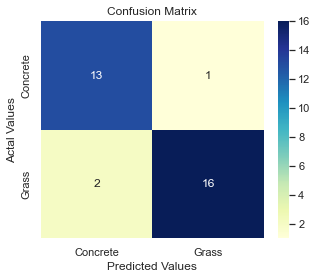

Epoch: 29, Loss: 0.09, Accuracy on training set is: 99.22
Epoch: 29, Loss: 0.15, Accuracy on testing set is: 93.75
[[13  1]
 [ 1 17]]


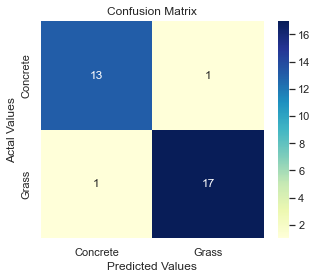

Epoch: 30, Loss: 0.09, Accuracy on training set is: 98.44
Epoch: 30, Loss: 0.13, Accuracy on testing set is: 100.00
[[14  0]
 [ 0 18]]


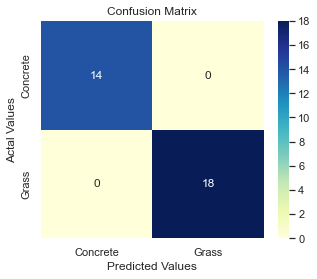

Epoch: 31, Loss: 0.09, Accuracy on training set is: 99.22
Epoch: 31, Loss: 0.16, Accuracy on testing set is: 96.88
[[14  0]
 [ 1 17]]


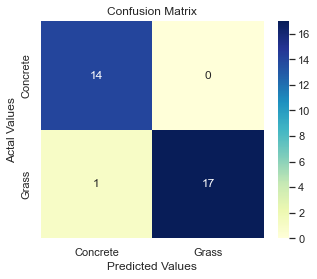

Epoch: 32, Loss: 0.09, Accuracy on training set is: 98.44
Epoch: 32, Loss: 0.21, Accuracy on testing set is: 87.50
[[12  2]
 [ 2 16]]


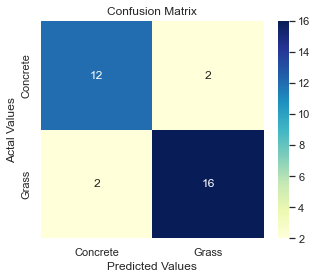

Epoch: 33, Loss: 0.08, Accuracy on training set is: 99.22
Epoch: 33, Loss: 0.16, Accuracy on testing set is: 96.88
[[14  0]
 [ 1 17]]


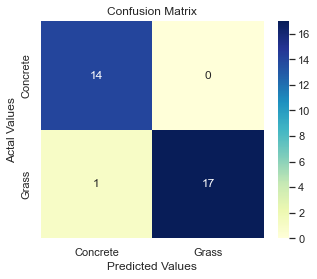

Epoch: 34, Loss: 0.06, Accuracy on training set is: 99.22
Epoch: 34, Loss: 0.10, Accuracy on testing set is: 100.00
[[14  0]
 [ 0 18]]


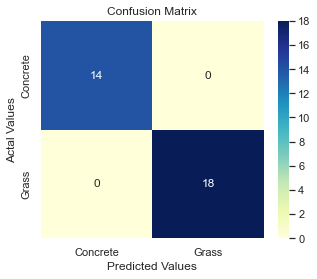

Epoch: 35, Loss: 0.07, Accuracy on training set is: 98.44
Epoch: 35, Loss: 0.12, Accuracy on testing set is: 96.88
[[14  0]
 [ 1 17]]


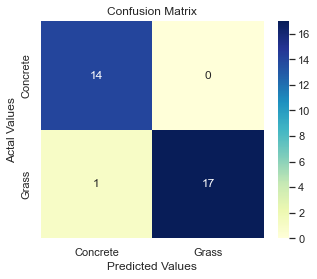

Epoch: 36, Loss: 0.07, Accuracy on training set is: 98.44
Epoch: 36, Loss: 0.12, Accuracy on testing set is: 93.75
[[14  0]
 [ 2 16]]


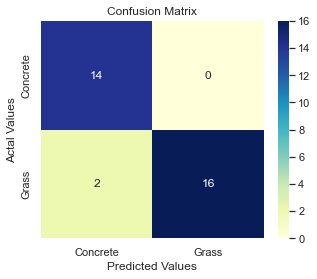

Epoch: 37, Loss: 0.07, Accuracy on training set is: 100.00
Epoch: 37, Loss: 0.14, Accuracy on testing set is: 93.75
[[14  0]
 [ 2 16]]


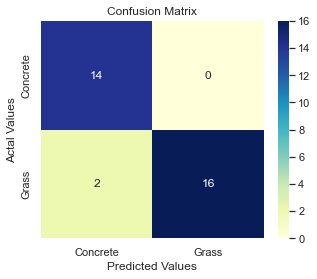

Epoch: 38, Loss: 0.06, Accuracy on training set is: 100.00
Epoch: 38, Loss: 0.12, Accuracy on testing set is: 93.75
[[13  1]
 [ 1 17]]


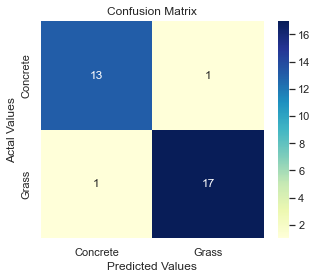

Epoch: 39, Loss: 0.06, Accuracy on training set is: 100.00
Epoch: 39, Loss: 0.11, Accuracy on testing set is: 96.88
[[14  0]
 [ 1 17]]


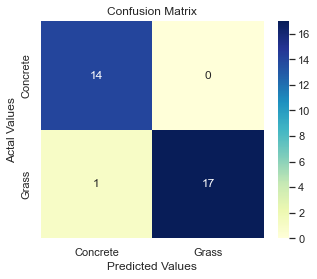

Epoch: 40, Loss: 0.06, Accuracy on training set is: 98.44
Epoch: 40, Loss: 0.13, Accuracy on testing set is: 96.88
[[14  0]
 [ 1 17]]


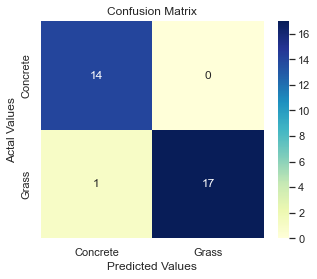

Epoch: 41, Loss: 0.05, Accuracy on training set is: 100.00
Epoch: 41, Loss: 0.09, Accuracy on testing set is: 96.88
[[14  0]
 [ 1 17]]


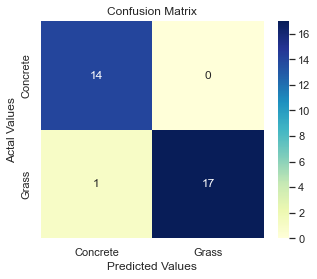

Epoch: 42, Loss: 0.06, Accuracy on training set is: 99.22
Epoch: 42, Loss: 0.09, Accuracy on testing set is: 96.88
[[14  0]
 [ 1 17]]


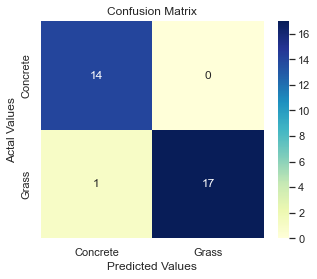

Epoch: 43, Loss: 0.06, Accuracy on training set is: 98.44
Epoch: 43, Loss: 0.07, Accuracy on testing set is: 100.00
[[14  0]
 [ 0 18]]


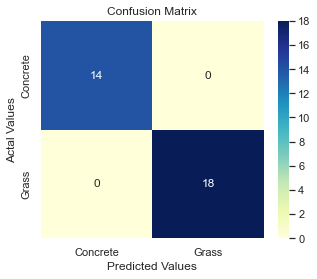

Epoch: 44, Loss: 0.05, Accuracy on training set is: 100.00
Epoch: 44, Loss: 0.11, Accuracy on testing set is: 100.00
[[14  0]
 [ 0 18]]


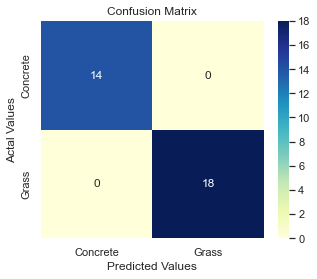

Epoch: 45, Loss: 0.06, Accuracy on training set is: 98.44
Epoch: 45, Loss: 0.12, Accuracy on testing set is: 90.62
[[13  1]
 [ 2 16]]


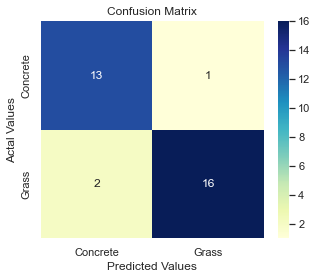

Epoch: 46, Loss: 0.05, Accuracy on training set is: 100.00
Epoch: 46, Loss: 0.12, Accuracy on testing set is: 93.75
[[13  1]
 [ 1 17]]


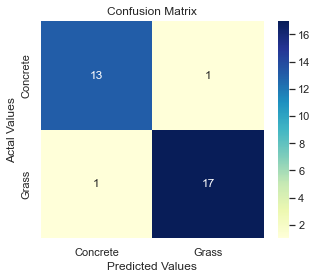

Epoch: 47, Loss: 0.05, Accuracy on training set is: 99.22
Epoch: 47, Loss: 0.08, Accuracy on testing set is: 96.88
[[13  1]
 [ 0 18]]


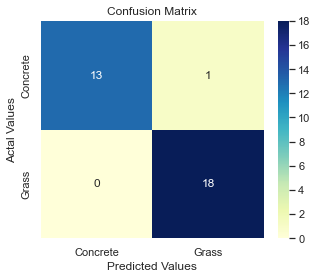

Epoch: 48, Loss: 0.04, Accuracy on training set is: 100.00
Epoch: 48, Loss: 0.14, Accuracy on testing set is: 96.88
[[13  1]
 [ 0 18]]


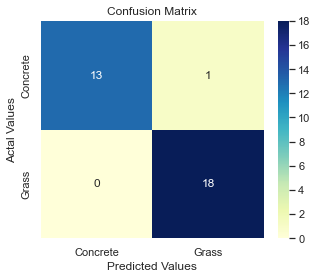

Epoch: 49, Loss: 0.05, Accuracy on training set is: 100.00
Epoch: 49, Loss: 0.08, Accuracy on testing set is: 100.00
[[14  0]
 [ 0 18]]


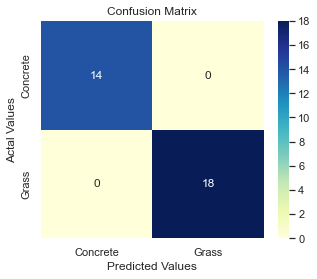

In [ ]:
test_accu = []
train_accu= []
train_losses =[]
test_losses =[]
for epoch in range(num_epochs):
        train(model,train_loader,optimizer,scheduler)
        test(model,test_loader)

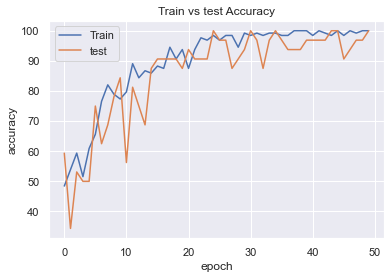

In [ ]:
plt.plot(train_accu)
plt.plot(test_accu)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','test'])
plt.title('Train vs test Accuracy')

plt.show()

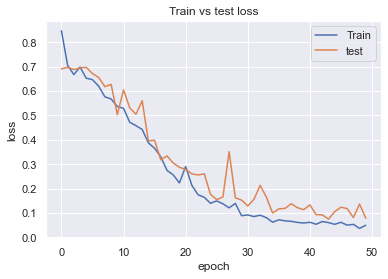

In [ ]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','test'])
plt.title('Train vs test loss')

plt.show()

In [ ]:
# predict one of the data 

waveform,label=myds[30]

def predict(model,inputs,labels):
    model.eval()
    inputs=torch.unsqueeze(inputs,0)
    with torch.no_grad():
        predictions=model(inputs)
        predictions = np.round(predictions)
    return predictions,labels
  
prediction,label=predict(model,waveform,label)
print(prediction,label)

tensor([[0.]]) 0


In [ ]:
test_accuarcy = 0.0
for samples, labels in test_loader:
    with torch.no_grad():
        model.eval()
        samples, labels = samples, labels
        inputs_m, inputs_s = samples.mean(), samples.std()
        samples = (samples - inputs_m) / inputs_s
        output = model(samples)
        pred = np.round(output)
        pred= pred.reshape(1,batch_size)
        print('pred',pred)
        print('targrt', labels)
        correct = pred.eq(labels)
        #print(correct.float())
        test_accuarcy += torch.mean(correct.float())
        #print('test_accuarcy',test_accuarcy)
print('Accuracy of the network on {} test images: {}%'.format(len(val_ds), round(test_accuarcy.item()*100.0/len(test_loader), 2)))


pred tensor([[1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
targrt tensor([1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1])
pred tensor([[1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.]])
targrt tensor([1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1])
Accuracy of the network on 32 test images: 93.75%


In [ ]:
# prepare to count predictions for each class
classes = ('Concrete', 'Grass')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


# again no gradients needed
with torch.no_grad():
    for data in  test_loader:
        samples, labels = data[0], data[1]
        inputs_m, inputs_s = samples.mean(), samples.std()
        samples = (samples - inputs_m) / inputs_s
        outputs = model(samples)
        predictions = np.round(outputs)
        #collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

            

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Concrete is 92.9 %
Accuracy for class: Grass is 94.4 %
